# CLUST Motion Tracking Project
Mélanie Bernhardt - ETH Zurich - Data Science MSc

This notebook provides a simple way to train the model, to predict the location of features from a saved model and to visualize the predictions. 

### First set up the environment
WARNING: in order to be able to run this notebook the `DATA_PATH`, `EXP_PATH`and `TEST_PATH` have to be properly set prior to starting the jupyter server. 

In [15]:
from dataLoader import DataLoader, compute_euclidean_distance, prepare_input_img
from block_matching_utils import *
from network import create_model
import os
import numpy as np
from custom_KFold import MyKFold
from PIL import Image
import pandas as pd
from tensorflow import keras
import logging
import skimage
import matplotlib.pyplot as plt
from utils import get_logger, get_default_params, plot_img_template
from global_tracking import train, predict
from matplotlib.patches import Rectangle
from IPython import display
import time
# ============ DATA AND SAVING DIRS SETUP ========== #
data_dir = os.getenv('DATA_PATH')
test_dir = os.getenv('TEST_PATH')
exp_dir = os.getenv('EXP_PATH')

## Define the parameters of the experiment

In [4]:
exp_name = 'saving_dir'
params_dict = {'dropout_rate': 0.5, 'n_epochs': 25,
               'h3': 0, 'embed_size': 128, 'width': 80}

checkpoint_dir = os.path.join(exp_dir, exp_name)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
params_dict = get_default_params(params_dict)

## Option 1: train the model from scratch
If a validation generator is provided then it uses early stopping else not. `train` automatically saves the model weigths and the temporal estimators to the checkpoint dir (necessary for `predict` to work properly).

In [ ]:
traindirs = np.asarray([dI for dI in os.listdir(data_dir) if (
                        os.path.isdir(os.path.join(data_dir, dI))
                        and not dI == 'feats_matrices')])
model, est_c1, est_c2 = train(traindirs,
                              upsample=False, 
                              params_dict=params_dict,
                              checkpointdir=checkpoint_dir,
                              logger=None,
                              validation_gen=None)

## Option 2: Predict from a saved model
The `predict` function restores the models saved in the `checkpoint_dir`. It runs computes the feature location for every frame of every sequences in the test directories. For each test sequence, the results are saved in a tab separated file named `SequenceName_PointNumber.txt` (as required by the submission format of the CLUST Challenge). The files are also stored in the `checkpoint_dir`.

In [ ]:
testdirs = np.asarray([dI for dI in os.listdir(test_dir) if (
                        os.path.isdir(os.path.join(test_dir, dI))
                        and not dI == 'feats_matrices')])
predict(testdirs, checkpoint_dir, data_dir, params_dict)

## Option 3: Run the cross-validation on the whole procedure
Runs the across-sequence cross-validation. Each neural model + temporal models are trained on 20 sequences and then predictions are computed for the remaining 4 sequences (5-folds). The results are recorded in a `logfile.log` in the checkpoint directory.  

In [ ]:
# ========== LOGGER SETUP ======== #
logger = get_logger(checkpoint_dir)

# ========= PRINT CONFIG TO LOG ======== #
logger.info('Running %s experiment ...' % exp_name)
logger.info('\n Settings for this expriment are: \n')
for key in params_dict.keys():
    logger.info('  {}: {}'.format(key.upper(), params_dict[key]))
logger.info('Saving checkpoint to {}'.format(checkpoint_dir))

# ======== KFold iterator ========= #
np.random.seed(seed=42)
kf = MyKFold(data_dir, n_splits=5)
fold_iterator = kf.getFolderIterator()

# ======== Run global CV ======= #
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.666)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
tf.keras.backend.set_session(sess)
run_global_cv(fold_iterator, logger, params_dict, upsample=False)

## Visualize your predictions

### Get the prediction and the ground truth if available

In [7]:
exp_to_visualize = ''
type_data = 'training'
checkpoint_dir = os.path.join(exp_dir, exp_to_visualize)
sequence_to_visualize = 'MED-02-3' # data folder to get the images from
feature_to_visualize = 'MED-02-3_4.txt'# name of the .txt file
if type_data=='training':
    img_dir = os.path.join(data_dir, sequence_to_visualize, 'Data')
else:
    img_dir = os.path.join(test_dir, sequence_to_visualize, 'Data')
pred_feat1 = pd.read_csv(os.path.join('/Users/melaniebernhardt/Downloads', # exp_to_visualize 
                                      feature_to_visualize),
                                     sep=',', #'\s+
                                     decimal='.', header=None, names = ['id', 'c1','c2'])
if type_data=='training':
    annotation_dir = os.path.join(data_dir, sequence_to_visualize, 'Annotation')
    true_feat1 = pd.read_csv(os.path.join(annotation_dir, feature_to_visualize),
                                         sep='\s+',
                                         decimal='.', header=None, names = ['id', 'c1','c2'])

### Visualize the initial point with the template

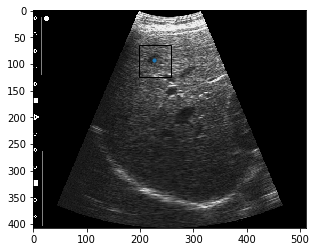

In [10]:
i = 1
c1, c2 = pred_feat1.loc[pred_feat1['id']==i, ['c1', 'c2']].values[0]
try:
    img = np.asarray(Image.open(os.path.join(img_dir, '{:04d}.png'.format(int(i)))))
except FileNotFoundError:
    img = np.asarray(Image.open(os.path.join(img_dir, '{:05d}.png'.format(int(i)))))
plot_img_template(c1, c2, img, width=60, height=60)

### Visualize the temporal evolution of feature location

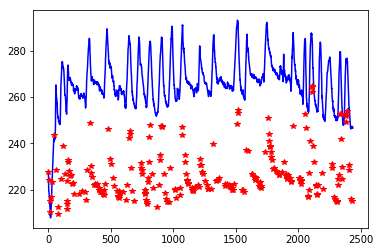

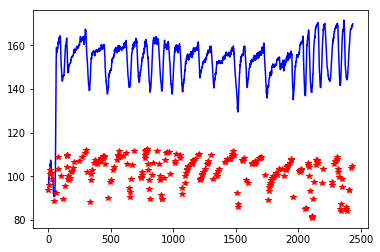

In [13]:
plt.plot(pred_feat1.id, pred_feat1.c1, 'b')
plt.plot(true_feat1.id, true_feat1.c1, 'r*')
plt.show()
plt.plot(pred_feat1.id, pred_feat1.c2, 'b')
plt.plot(true_feat1.id, true_feat1.c2, 'r*')
plt.show()

### Visualize the tracking as a video

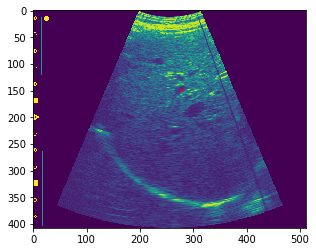

None

In [17]:
c1_list = pred_feat1.loc[:, 'c1'].values
c2_list = pred_feat1.loc[:,'c2'].values
for i in range(1,2000,50):
    try:
        img = np.asarray(Image.open(os.path.join(img_dir, '{:05d}.png'.format(i))))
    except FileNotFoundError:
        img = np.asarray(Image.open(os.path.join(img_dir, '{:04d}.png'.format(i))))
    plt.clf()
    plt.imshow(img)
    plt.scatter(c1_list[i-1], c2_list[i-1], 3, 'r')
    display.clear_output(wait=True)
    display.display(plt.show())
    time.sleep(1)